## Squared Loss

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


### Loading data and pre-processing

A similar reprocessing as the one in the paper is done on the MNIST dataset. The training set is then restricted to 10,000 samples, and the test set to 2,000 samples. Each image, originally a 28x28 grid of pixel values, is flattened into a single vector and normalized so that all values fall between 0 and 1, and the digit labels are converted into a format called one-hot encoding, where each digit is represented as a unique vector instead of a single number.\\
All of this helps with computational efficiency, improvements for the model to learn and following a similar guideline as the document in discussion.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:10000].reshape(10000, -1) / 255.0
X_test = X_test[:2000].reshape(2000, -1) / 255.0
y_train = y_train[:10000]
y_test = y_test[:2000]

y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

### RFF Model

Now, there are definitions of some useful functions and training procedures. The idea behind RFF is to approximate kernel function, which allows a linear model to capture non-linear patterns in the data. \\

The first function defined transforms the input data using random projections and applies sine and cosine functions to create new feature representations, given the function provided in the document. \\

The second function trains a linear model using the generated Fourier features. It first converts the input data into PyTorch tensors and moves them to the GPU. It then generates a random projection matrix, which is used to compute the new feature representations. Finally, it solves a least-squares optimization problem, finding the best set of model parameters that minimize the difference between the transformed features and the target labels. This procedure is done to follow the same guideline as the document in discussion (in order to further train a RFF model, and with this, obtain the metrics wanted).

In [ ]:
def generate_rff_features_torch(X, v):
    dot_product = torch.matmul(X, v.T)

    real_part = torch.cos(dot_product)
    imag_part = torch.sin(dot_product)

    Z = torch.cat([real_part, imag_part], dim=1)
    return Z


def train_rff_model_torch(X_train, y_train, N):
    d = X_train.shape[1]

    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)

    v = torch.randn(N, d, device=device)

    Z_train = generate_rff_features_torch(X_train_torch, v)

    ZtZ = torch.matmul(Z_train.T, Z_train)
    Zty = torch.matmul(Z_train.T, y_train_torch)
    a_opt = torch.linalg.solve(ZtZ, Zty)

    return a_opt, Z_train, v

In [ ]:
N_values = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,10500,12000,14000,16000,25000,30000]) // 2
print(N_values)

[  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5250  6000
  7000  8000 12500 15000]


### Training RFF Model

After this, an iteration over different values of N is performed to train the model and compute the key metrics, including train risk, test risk, and the l2 norm of the learned coefficients. The loop starts by initializing empty lists to store these values. For each value of N, the model is trained using the functions defined and after this, the train and test risks are computed using the squared loss function. Additionally, the l2 norm of the learned coefficients, $\|a_{\text{opt}}\|_2$, is stored as well.

Notably, no regularization methods are applied in this training procedure. This is intentional to observe the double descent phenomenon that the paper in question refers to.

In [ ]:
test_risks = []
train_risks = []
l2_norms = []
np.random.seed(89898)
for N in N_values:
    a_opt, Z_train, v = train_rff_model_torch(X_train, y_train_onehot, N)

    y_train_torch = torch.tensor(y_train_onehot, dtype=torch.float32).to(device)
    y_test_torch = torch.tensor(y_test_onehot, dtype=torch.float32).to(device)

    X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
    Z_test = generate_rff_features_torch(X_test_torch, v)

    train_risk = torch.mean(torch.sum((Z_train @ a_opt - y_train_torch) ** 2, axis=1)).cpu().item()
    test_risk = torch.mean(torch.sum((Z_test @ a_opt - y_test_torch) ** 2, axis=1)).cpu().item()

    l2_norm = torch.linalg.norm(a_opt).cpu().item()

    train_risks.append(train_risk)
    test_risks.append(test_risk)
    l2_norms.append(l2_norm)

### Plots

There are two plots in this section for the Test Risk. This was to observe if running the code two times would show a significant difference in our results obtained from the first attempt. So, for the second block, we restarted the collab session and run everything again (reprocessing and definition of functions, training loop), to notice possible changes. We conclude there is certain randomness and instability when surpassing the threshold of N=10000.
There are two plots as well for train risk and l2 norm (following the same)



#### Reference
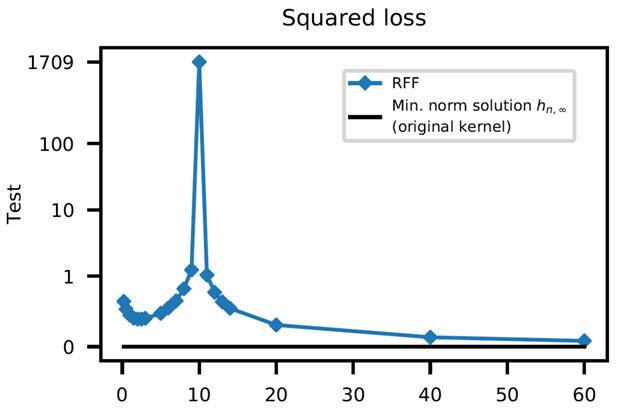

#### Result

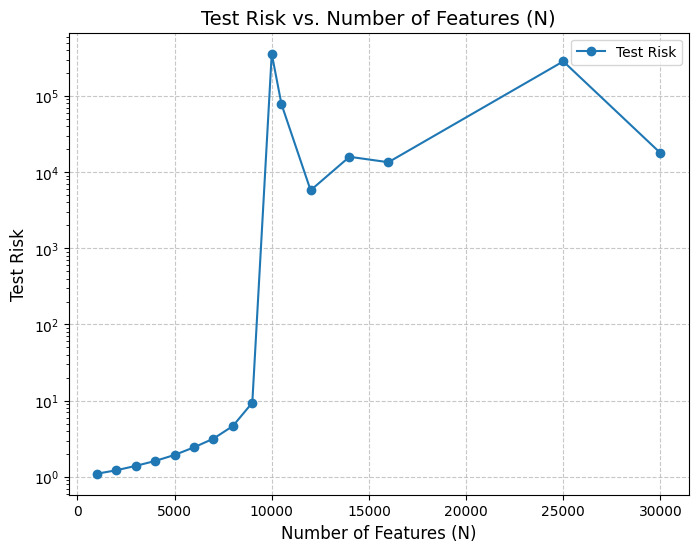

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N_values = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,10500,12000,14000,16000,25000,30000])
# Plot 1: Test Risk vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, test_risks, marker='o', label='Test Risk')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Test Risk', fontsize=12)
plt.title('Test Risk vs. Number of Features (N)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')
#plt.xscale('log')
plt.legend(fontsize=10)
plt.show()

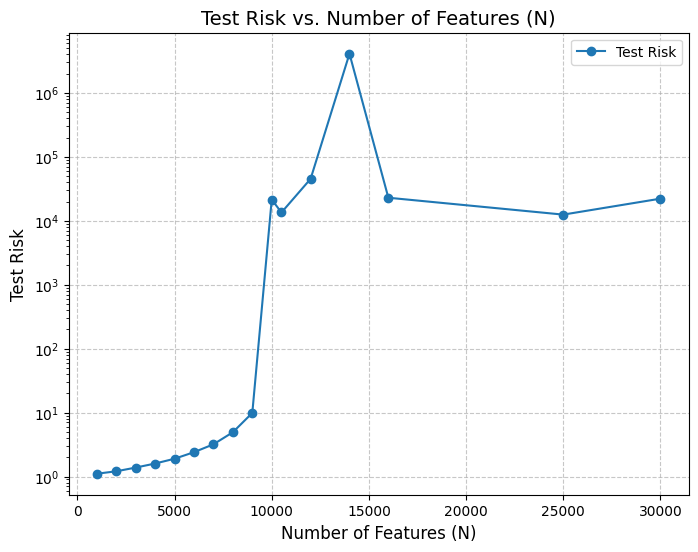

In [ ]:
N_values = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,10500,12000,14000,16000,25000,30000])
# Plot 1: Test Risk vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, test_risks, marker='o', label='Test Risk')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Test Risk', fontsize=12)
plt.title('Test Risk vs. Number of Features (N)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')
#plt.xscale('log')
plt.legend(fontsize=10)
plt.show()

#### Reference
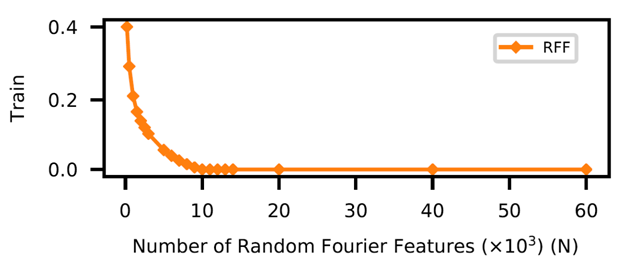

#### Result

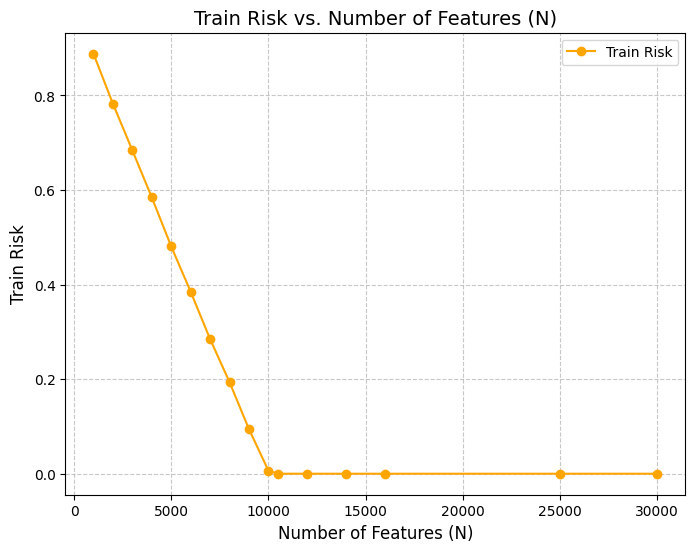

In [ ]:
# Plot 2: Train Risk vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, train_risks, marker='o', label='Train Risk', color='orange')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Train Risk', fontsize=12)
plt.title('Train Risk vs. Number of Features (N)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xscale('log')
plt.legend(fontsize=10)
plt.show()

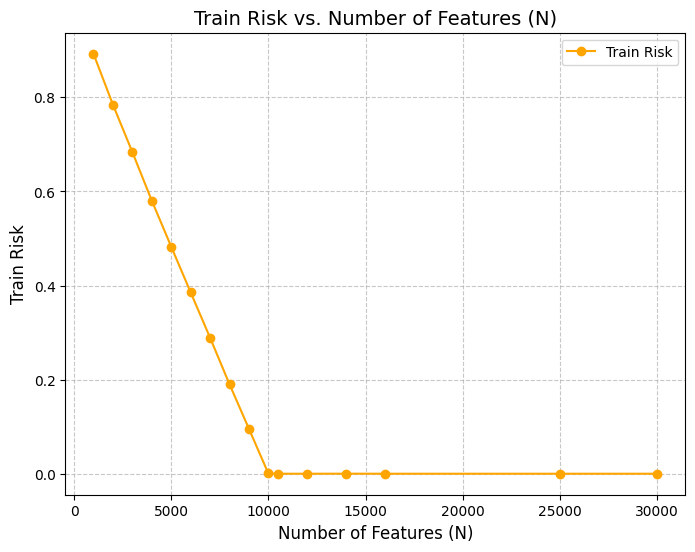

In [ ]:
# Plot 2: Train Risk vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, train_risks, marker='o', label='Train Risk', color='orange')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Train Risk', fontsize=12)
plt.title('Train Risk vs. Number of Features (N)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xscale('log')
plt.legend(fontsize=10)
plt.show()

#### Reference
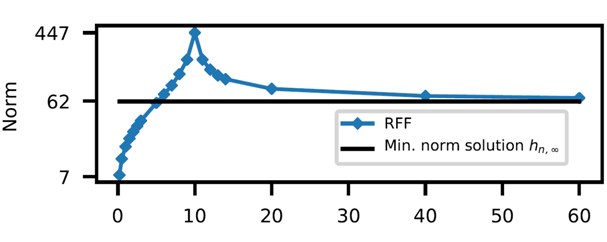

#### Result

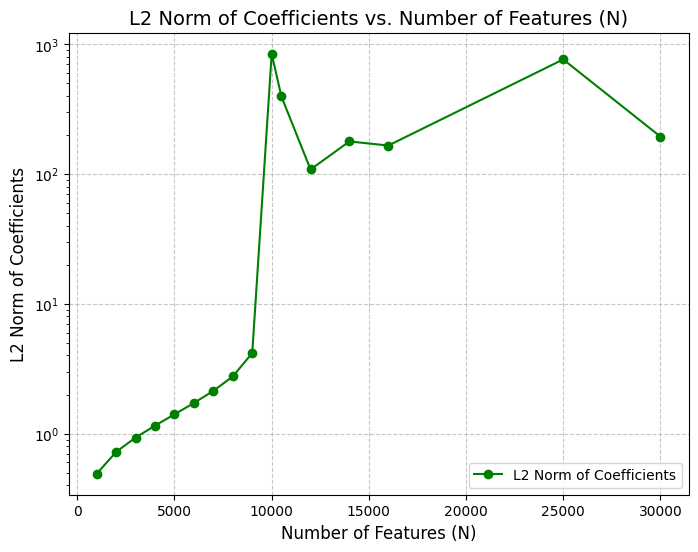

In [ ]:
# Plot 3: L2 Norm of Coefficients vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, l2_norms, marker='o', label='L2 Norm of Coefficients', color='green')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('L2 Norm of Coefficients', fontsize=12)
plt.title('L2 Norm of Coefficients vs. Number of Features (N)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')
plt.legend(fontsize=10)
plt.show()

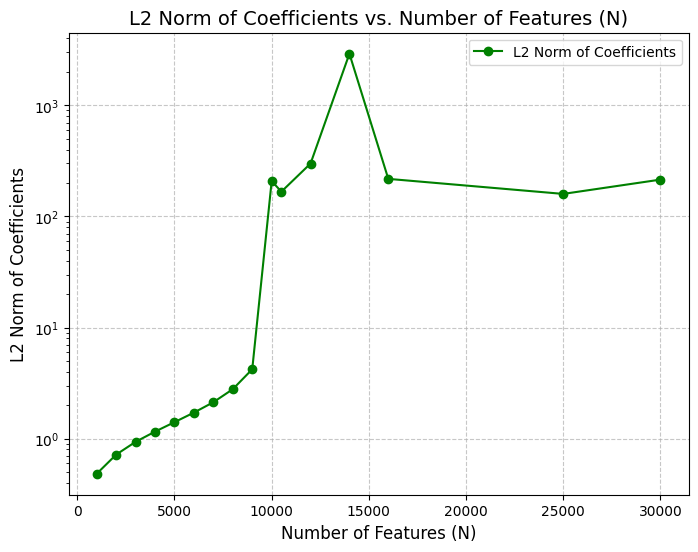

In [ ]:
# Plot 3: L2 Norm of Coefficients vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, l2_norms, marker='o', label='L2 Norm of Coefficients', color='green')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('L2 Norm of Coefficients', fontsize=12)
plt.title('L2 Norm of Coefficients vs. Number of Features (N)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')
plt.legend(fontsize=10)
plt.show()

### Zero one Loss

With Zero One Loss we provide the same procedure, with the only difference being using the Zero One Loss inseatd of Squared Loss. We also restarted collab for this session (because of memory), that is why the reprocessing and definitions are done again in the same way.

In [ ]:
import torch
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading data and pre-processing

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:10000].reshape(10000, -1) / 255.0
X_test = X_test[:2000].reshape(2000, -1) / 255.0
y_train = y_train[:10000]
y_test = y_test[:2000]

y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

### RFF Model

In [ ]:
def generate_rff_features_torch(X, v):
    dot_product = torch.matmul(X, v.T)
    real_part = torch.cos(dot_product)
    imag_part = torch.sin(dot_product)
    Z = torch.cat([real_part, imag_part], dim=1)
    return Z

def train_rff_model_torch(X_train, y_train, N):
    d = X_train.shape[1]

    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)

    v = torch.randn(N, d, device=device)

    Z_train = generate_rff_features_torch(X_train_torch, v)

    a_opt, _, _, _ = torch.linalg.lstsq(Z_train, y_train_torch)

    return a_opt, Z_train, v

### Training RFF Model

In [ ]:
N_values = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,10500,12000,14000,16000,25000,30000]) // 2

test_errors = []
train_errors = []
l2_norms = []

np.random.seed(89898)

for N in N_values:
    a_opt, Z_train, v = train_rff_model_torch(X_train, y_train_onehot, N)

    y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

    Z_test = generate_rff_features_torch(X_test_torch, v)

    train_preds = torch.argmax(Z_train @ a_opt, dim=1)
    test_preds = torch.argmax(Z_test @ a_opt, dim=1)

    train_error = (train_preds != y_train_torch).float().mean().cpu().item()
    test_error = (test_preds != y_test_torch).float().mean().cpu().item()

    l2_norm = torch.linalg.norm(a_opt).cpu().item()

    train_errors.append(train_error)
    test_errors.append(test_error)
    l2_norms.append(l2_norm)

### Plots

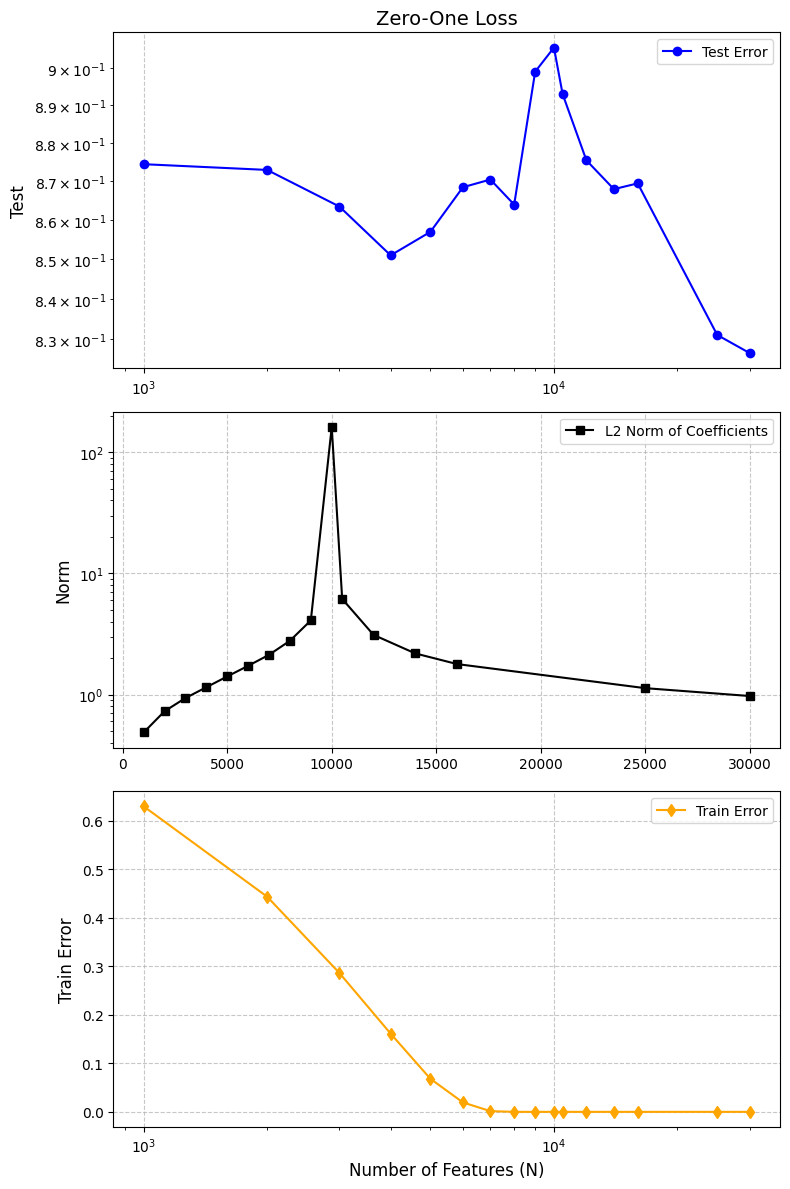

In [ ]:
N_values = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,10500,12000,14000,16000,25000,30000])

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot 1: Test Error vs. N
axes[0].plot(N_values, test_errors, marker='o', label='Test Error', color='blue')
axes[0].set_ylabel('Test', fontsize=12)
axes[0].set_title('Zero-One Loss', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].legend()

# Plot 2: L2 Norm of Weights
axes[1].plot(N_values, l2_norms, marker='s', label='L2 Norm of Coefficients', color='black')
axes[1].set_ylabel('Norm', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_yscale('log')
axes[0].set_xscale('log')
axes[1].legend()

# Plot 3: Train Error vs. N
axes[2].plot(N_values, train_errors, marker='d', label='Train Error', color='orange')
axes[2].set_xlabel('Number of Features (N)', fontsize=12)
axes[2].set_ylabel('Train Error', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_xscale('log')
axes[2].legend()

plt.tight_layout()
plt.show()

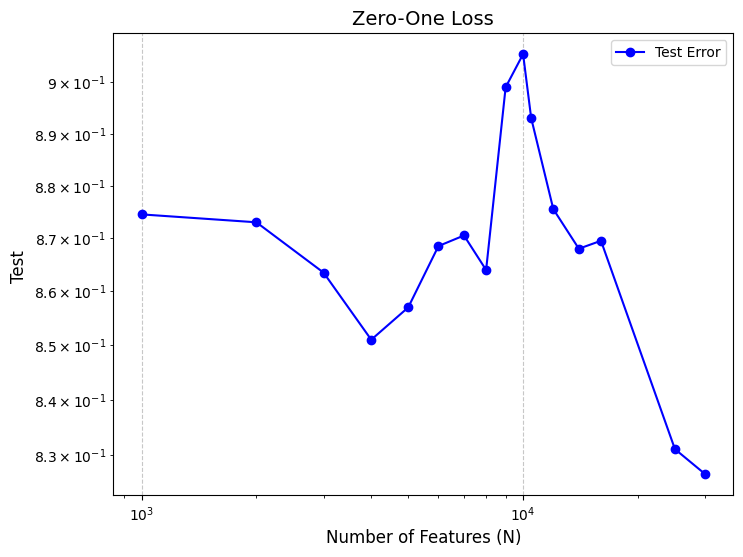

In [ ]:
import matplotlib.pyplot as plt

# Plot 1: Test Error vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, test_errors, marker='o', label='Test Error', color='blue')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Test ', fontsize=12)
plt.title('Zero-One Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

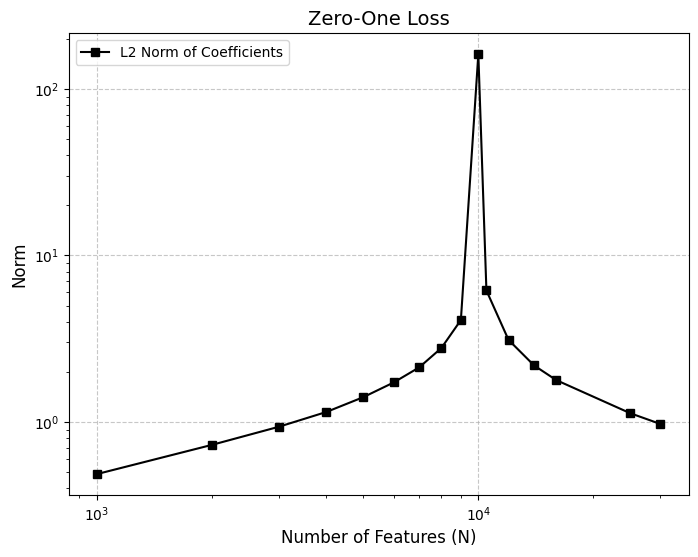

In [ ]:
# Plot 2: L2 Norm of Weights
plt.figure(figsize=(8, 6))
plt.plot(N_values, l2_norms, marker='s', label='L2 Norm of Coefficients', color='black')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Norm', fontsize=12)
plt.title('Zero-One Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

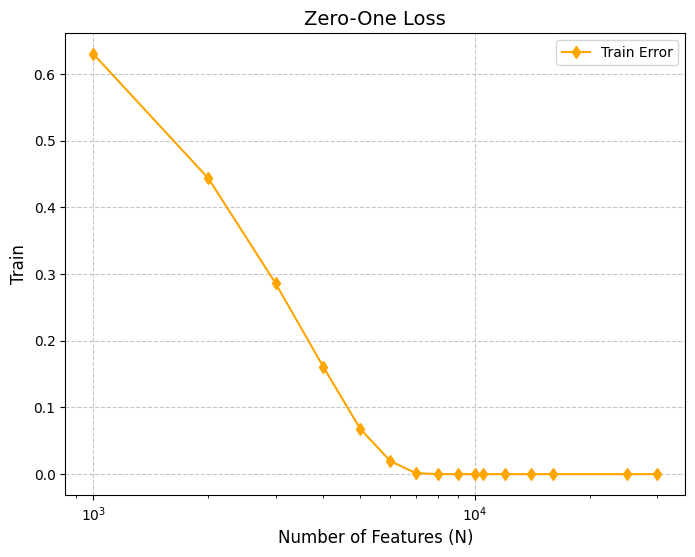

In [ ]:
# Plot 3: Train Error vs. N
plt.figure(figsize=(8, 6))
plt.plot(N_values, train_errors, marker='d', label='Train Error', color='orange')
plt.xlabel('Number of Features (N)', fontsize=12)
plt.ylabel('Train', fontsize=12)
plt.title('Zero-One Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.legend()
plt.show()